# [Source](https://www.kaggle.com/code/scratchpad/notebooka28c83a702/edit)

In [1]:
import torch
import pandas 
import numpy as np
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

/mnt/iusers01/fse-ugpgt01/compsci01/b84547bp/.conda/envs/Self_Model/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/mnt/iusers01/fse-ugpgt01/compsci01/b84547bp/.conda/envs/Self_Model/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Using same dataloader

In [2]:
"""
FERDataset
A class which inherits the pytorch dataset for storing and manipulating our input
"""
# Inherits Pytorch dataset
class FERDataset(Dataset):
    def __init__(self, dataframe, transform = None):
        # Constructor
        # (String) df: Instance of pandas dataframe with data already loaded
        # (Function) transform: Image processing function 
        
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        row = self.df.iloc[idx]

        pixels = np.fromstring(row['pixels'], sep=' ', dtype=np.uint8)
        img = pixels.reshape(48, 48) #48x48 to match FER2013

        # from greyscale to RGB
        img = Image.fromarray(img).convert("RGB")

        label = int(row['emotion'])

        # transform img
        if self.transform:
            img = self.transform(img)

        return img, label

    def get_emotion_class(self,emotion):
        return FERDataset(self.df[self.df['emotion'] == emotion],transform=self.transform)

    @property
    def classes(self):
        classes = self.df['emotion'].unique()
        classes.sort()
        return classes
    
    # Helper function to return distribution of each class in a dataset
    @property
    def dist(self):
        return self.df['emotion'].value_counts()
    

In [3]:
fer2013_dataframe = pandas.read_csv('./../data/FER2013/train.csv')
# we're going one back
dataset = FERDataset(dataframe=fer2013_dataframe)
print(len(dataset))
len(dataset.classes)
# Should be seven classes for FER2013

28709


7

In [4]:
# Defining some constants here to be able to map layers from other people's implementations to mine
from torchvision.models import resnet18
resnet18().fc.in_features
num_ftrs = resnet18().fc.in_features
latent_space = 256

In [5]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
dataset = FERDataset(dataframe=fer2013_dataframe,transform=transform)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)
img_shape = dataset[0][0].shape

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(len(dataset.classes), len(dataset.classes))
        
        self.model = nn.Sequential(
            nn.Linear(len(dataset.classes)+int(np.prod(img_shape)), 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )
    
    def forward(self, img, labels):
        d_in = torch.cat((img.view(img.size(0), -1), self.label_emb(labels)), -1)
        validity = self.model(d_in)
        return validity.view(-1)

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(len(dataset.classes),len(dataset.classes))

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            nn.Linear(latent_space + len(dataset.classes), 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )


        self.model = nn.Sequential(
            *block(latent_space + len(dataset.classes), 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
    
    def forward(self, img, labels):
        gen_input = torch.cat((self.label_emb(labels), img), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img

In [8]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

In [9]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-5)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [10]:
def generator_train_step(discriminator, generator, g_optimizer, batch_size,
                         latent_space, num_classes):
    generator.train()
    discriminator.eval()  # optional
    z = torch.randn(batch_size, latent_space, device=next(generator.parameters()).device)
    gen_labels = torch.randint(0, num_classes, (batch_size,), device=z.device)

    fake_images = generator(z, gen_labels)
    D_fake = discriminator(fake_images, gen_labels).view(batch_size)

    g_loss = -D_fake.mean()

    g_optimizer.zero_grad(set_to_none=True)
    g_loss.backward()
    g_optimizer.step()

    return g_loss.item()

In [11]:
def discriminator_train_step(discriminator, generator, d_optimizer, real_images, labels,
                             latent_space, lambda_gp=10.0):
    discriminator.train()
    generator.eval()  # optional, but fine for D step
    B = real_images.size(0)

    z = torch.randn(B, latent_space, device=real_images.device)
    fake_images = generator(z, labels)  # IMPORTANT: same labels

    D_real = discriminator(real_images, labels).view(B)
    D_fake = discriminator(fake_images.detach(), labels).view(B)

    # GP
    alpha = torch.rand(B, 1, 1, 1, device=real_images.device)
    x_hat = alpha * real_images + (1 - alpha) * fake_images.detach()
    x_hat.requires_grad_(True)

    D_hat = discriminator(x_hat, labels).view(B)
    grads = torch.autograd.grad(
        outputs=D_hat.sum(), inputs=x_hat,
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    grads = grads.view(B, -1)
    gp = ((grads.norm(2, dim=1) - 1) ** 2).mean()

    d_loss = D_fake.mean() - D_real.mean() + lambda_gp * gp
    gap = D_real.mean() - D_fake.mean()
    
    d_optimizer.zero_grad(set_to_none=True)
    d_loss.backward()
    d_optimizer.step()

    
    return d_loss.item(), D_real.mean().item(), D_fake.mean().item(), gp.item(), gap.item()


Starting epoch 0...
Epoch 0 | Generator Loss: -0.8792 | Discriminator Loss: -53.4521


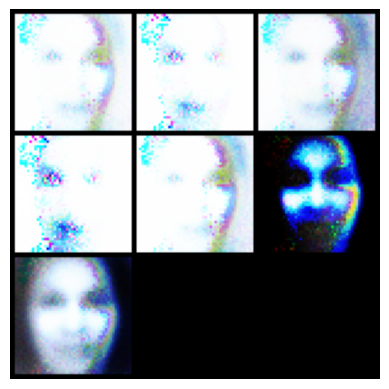

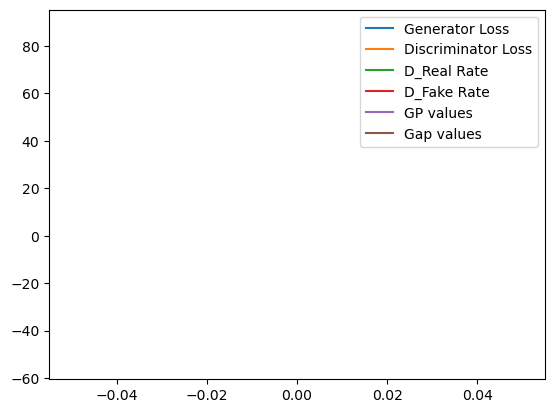

Starting epoch 1...
Epoch 1 | Generator Loss: -8.6359 | Discriminator Loss: -30.2086


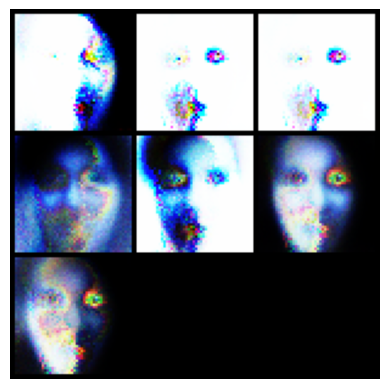

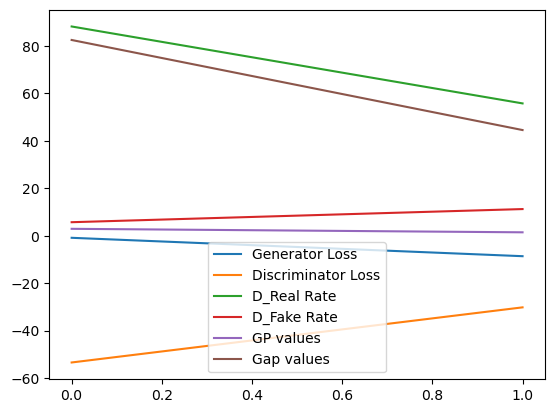

Starting epoch 2...
Epoch 2 | Generator Loss: -32.4015 | Discriminator Loss: -24.8116


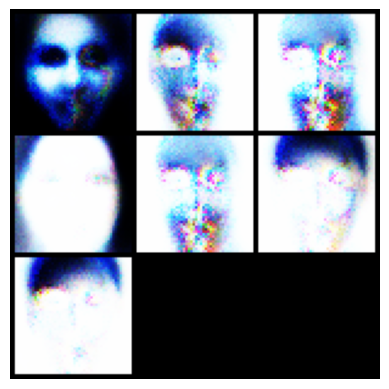

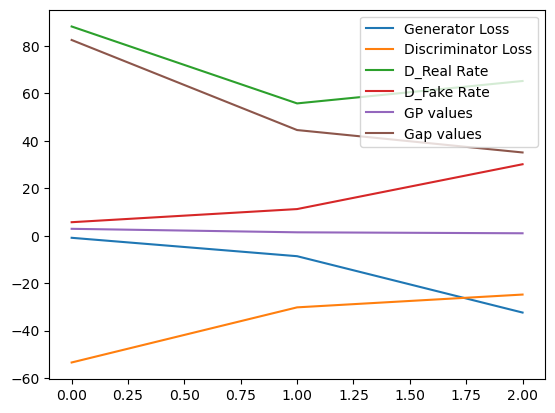

Starting epoch 3...
Epoch 3 | Generator Loss: -38.7924 | Discriminator Loss: -29.4744


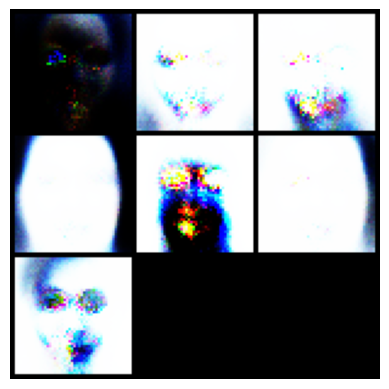

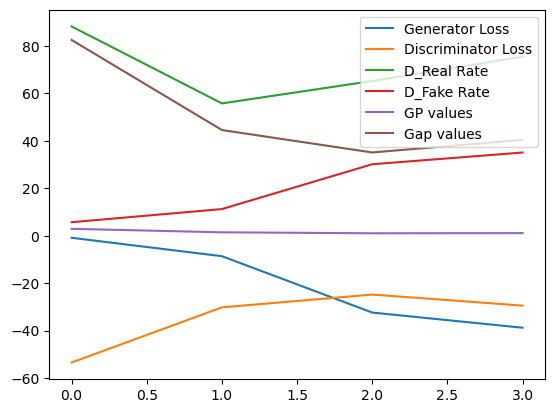

Starting epoch 4...
Epoch 4 | Generator Loss: -24.9207 | Discriminator Loss: -36.2761


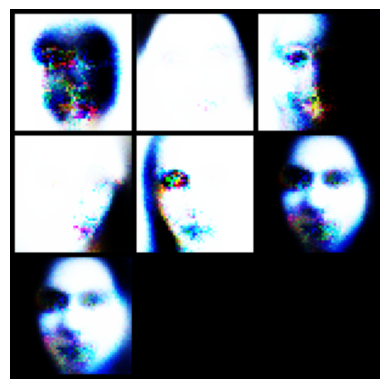

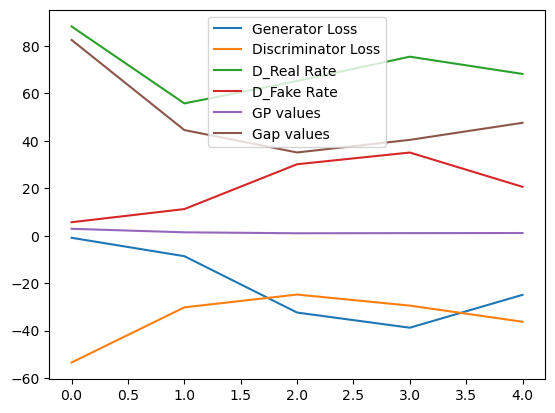

Starting epoch 5...
Epoch 5 | Generator Loss: -27.9414 | Discriminator Loss: -27.1915


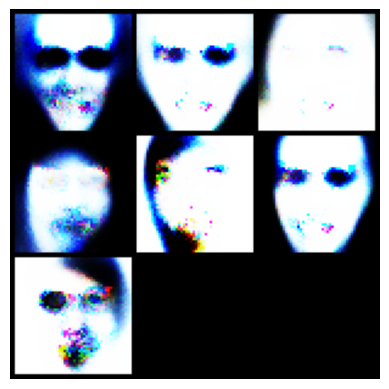

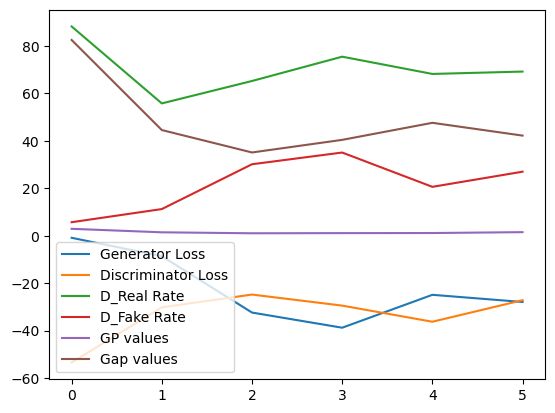

Starting epoch 6...
Epoch 6 | Generator Loss: -27.8110 | Discriminator Loss: -26.7883


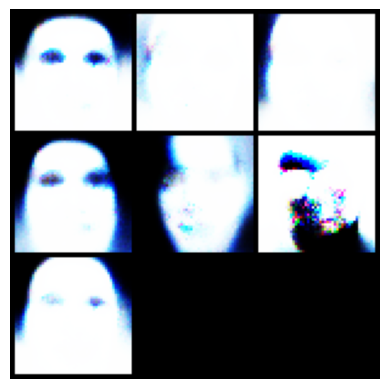

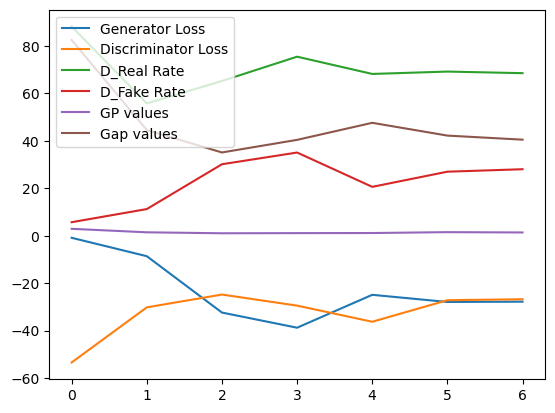

Starting epoch 7...
Epoch 7 | Generator Loss: -29.0416 | Discriminator Loss: -32.9443


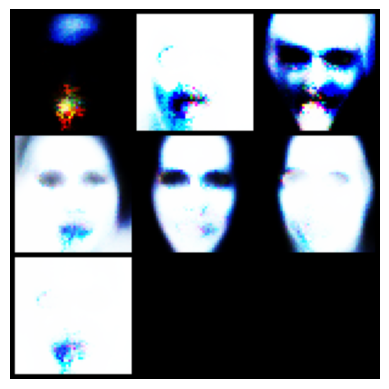

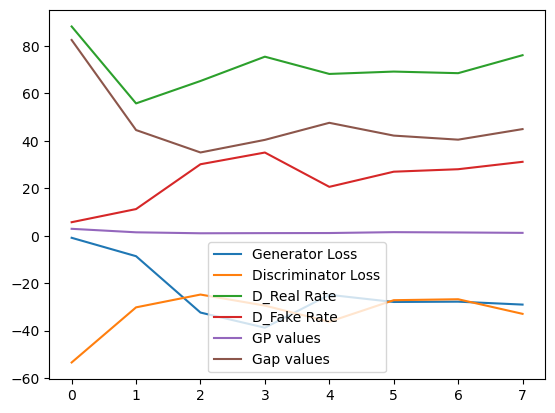

Starting epoch 8...
Epoch 8 | Generator Loss: -15.4075 | Discriminator Loss: -43.1380


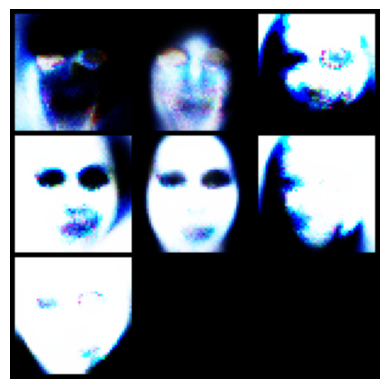

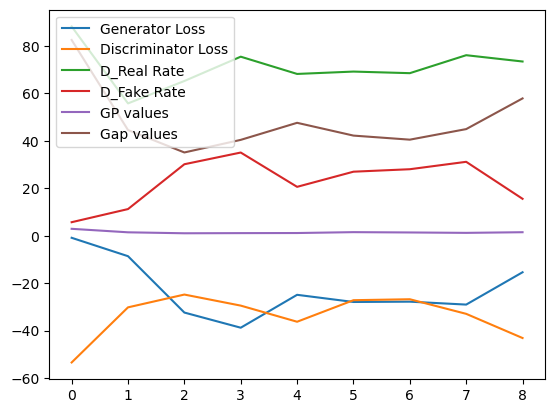

Starting epoch 9...
Epoch 9 | Generator Loss: -31.8958 | Discriminator Loss: -28.8579


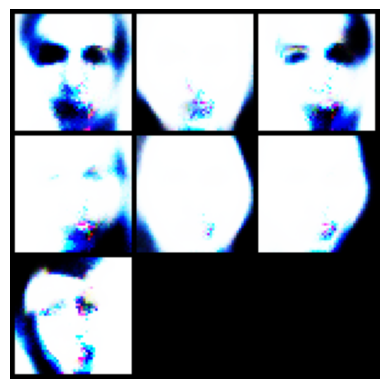

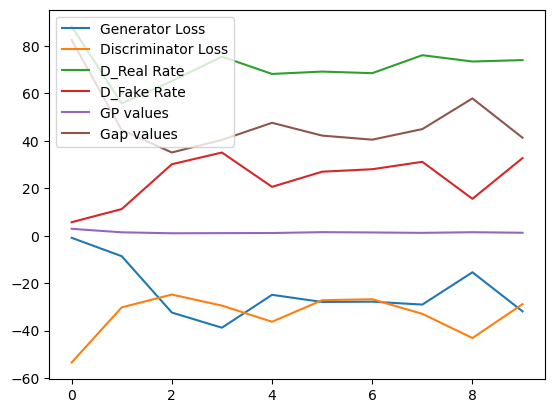

Starting epoch 10...
Epoch 10 | Generator Loss: -48.3485 | Discriminator Loss: -24.9537


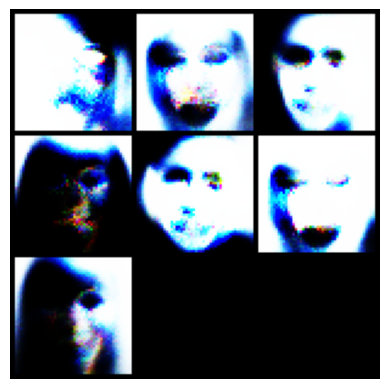

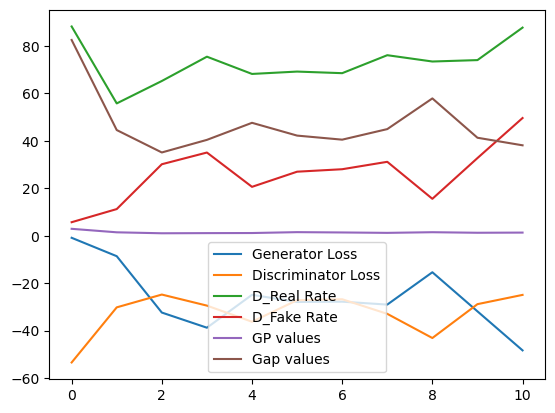

Starting epoch 11...
Epoch 11 | Generator Loss: -41.3293 | Discriminator Loss: -33.2029


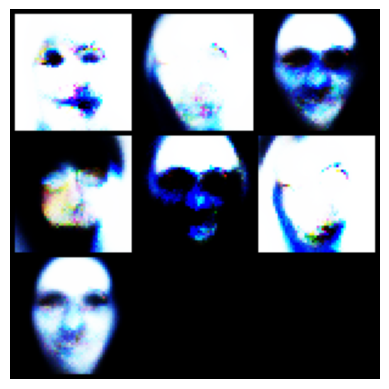

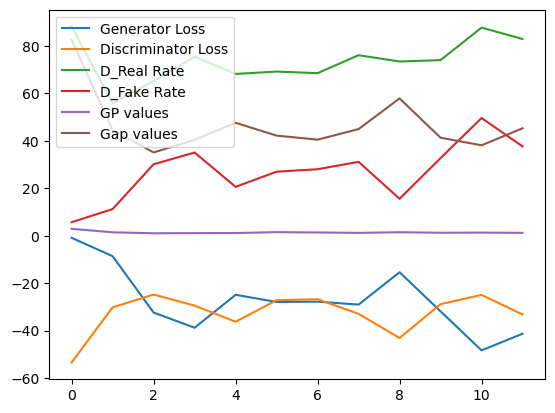

Starting epoch 12...
Epoch 12 | Generator Loss: -44.0085 | Discriminator Loss: -29.2934


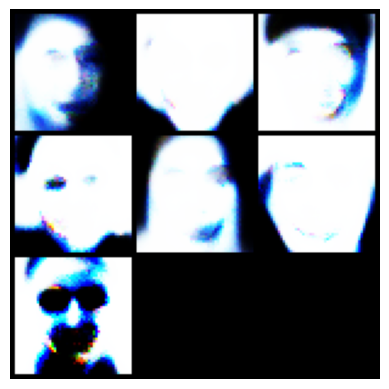

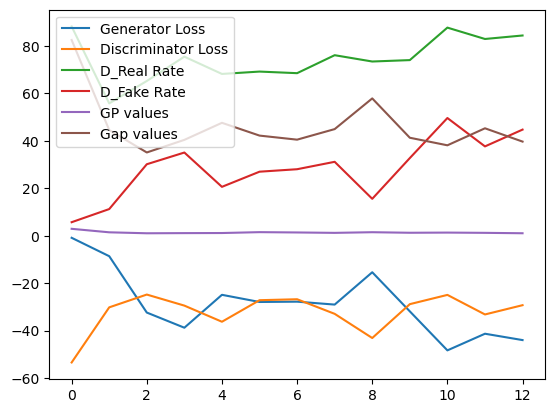

Starting epoch 13...
Epoch 13 | Generator Loss: -49.7787 | Discriminator Loss: -23.7069


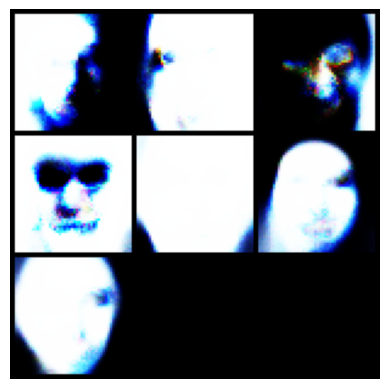

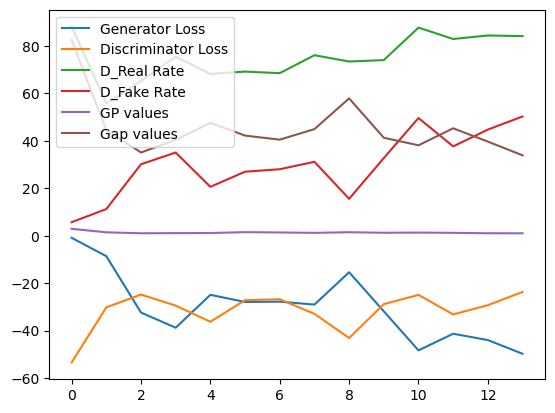

Starting epoch 14...
Epoch 14 | Generator Loss: -51.8730 | Discriminator Loss: -23.6479


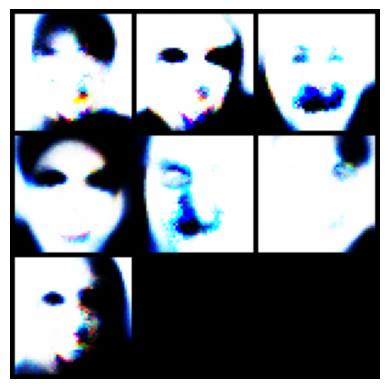

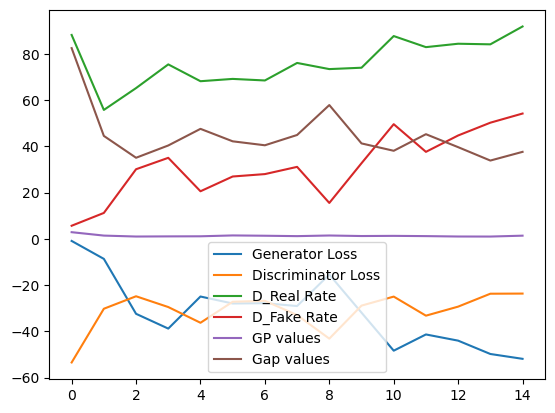

Starting epoch 15...
Epoch 15 | Generator Loss: -45.3399 | Discriminator Loss: -31.2918


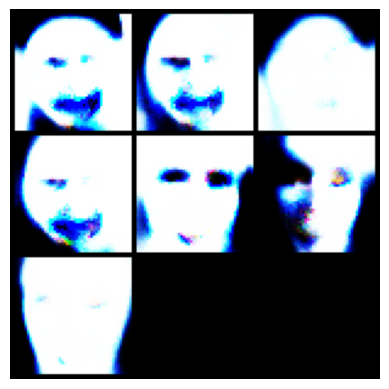

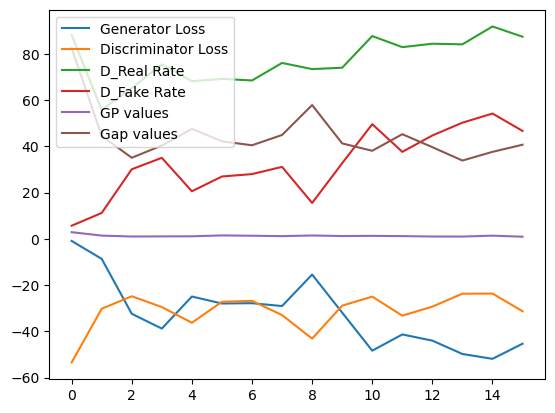

Starting epoch 16...
Epoch 16 | Generator Loss: -46.9541 | Discriminator Loss: -31.4361


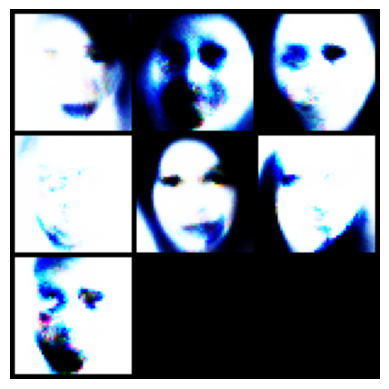

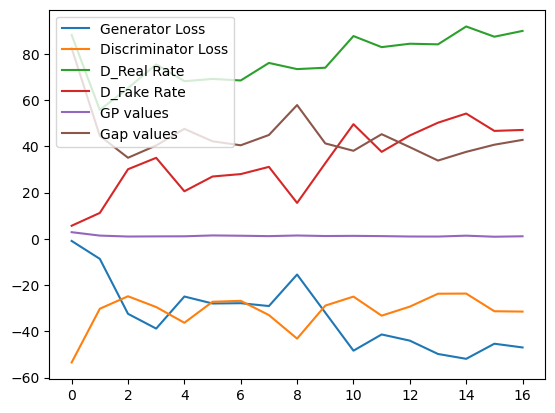

Starting epoch 17...
Epoch 17 | Generator Loss: -55.3741 | Discriminator Loss: -24.1166


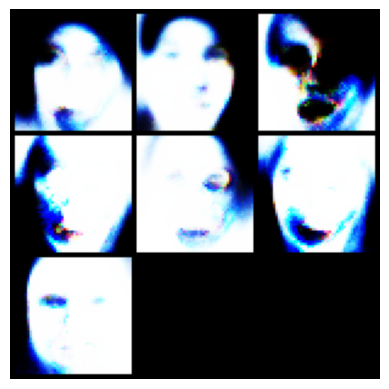

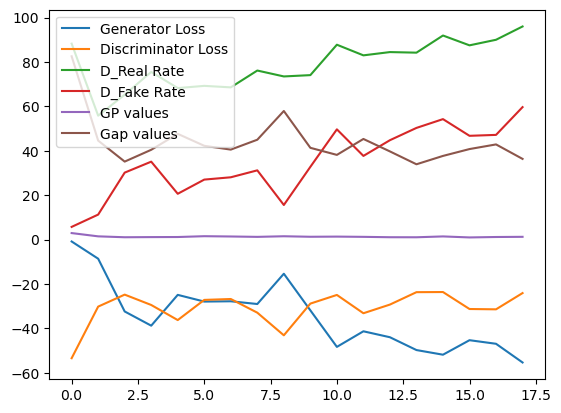

Starting epoch 18...
Epoch 18 | Generator Loss: -50.1251 | Discriminator Loss: -35.8629


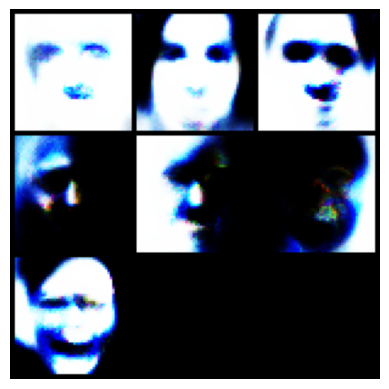

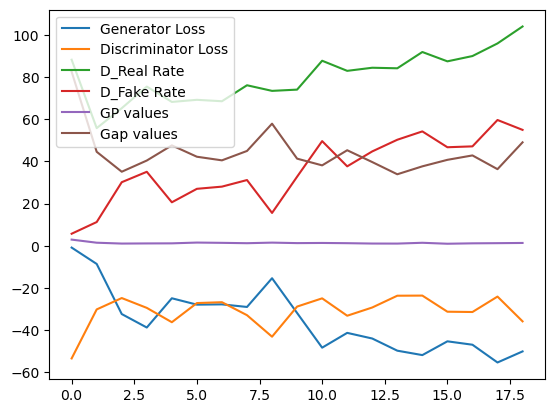

Starting epoch 19...
Epoch 19 | Generator Loss: -56.6861 | Discriminator Loss: -35.1922


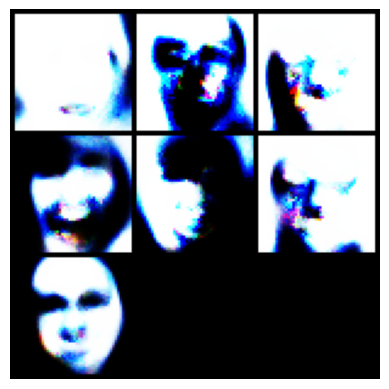

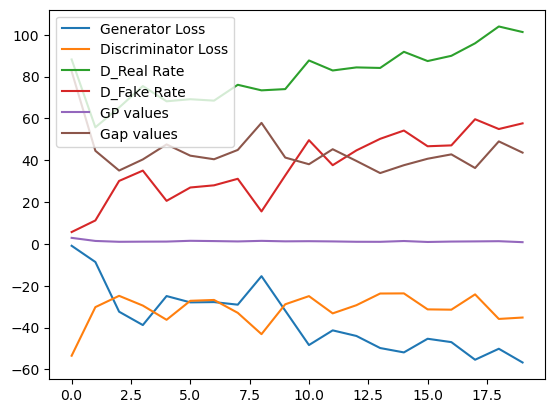

Starting epoch 20...
Epoch 20 | Generator Loss: -63.4451 | Discriminator Loss: -28.7835


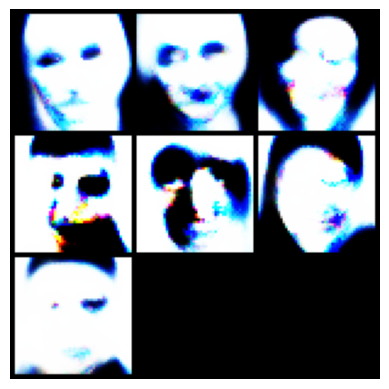

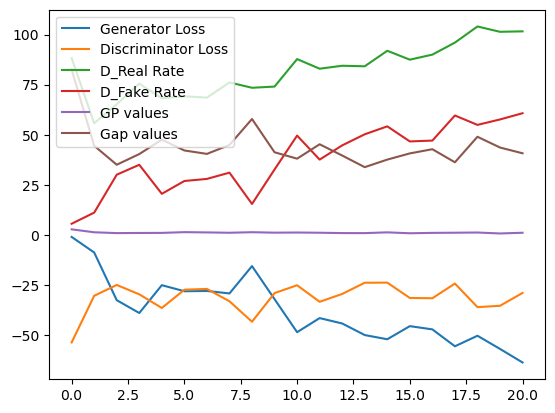

Starting epoch 21...
Epoch 21 | Generator Loss: -60.4300 | Discriminator Loss: -23.2067


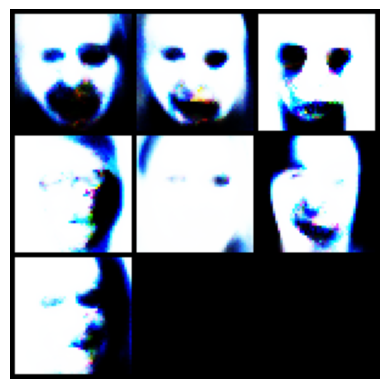

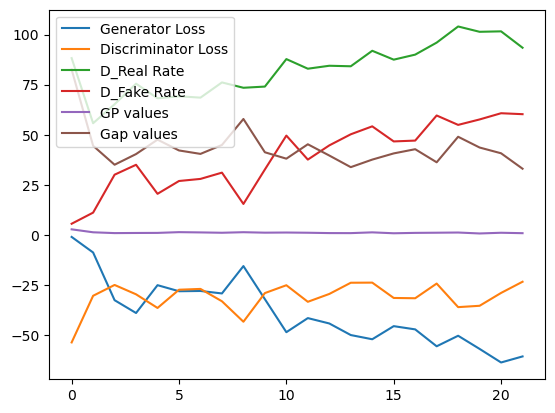

Starting epoch 22...
Epoch 22 | Generator Loss: -55.4789 | Discriminator Loss: -40.3588


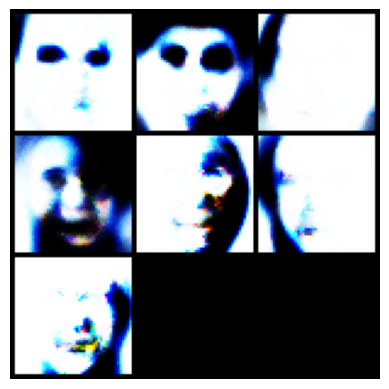

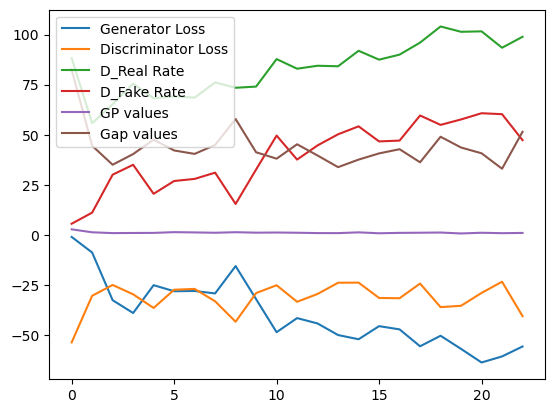

Starting epoch 23...
Epoch 23 | Generator Loss: -64.4204 | Discriminator Loss: -30.8209


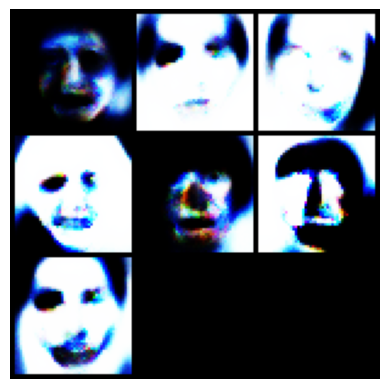

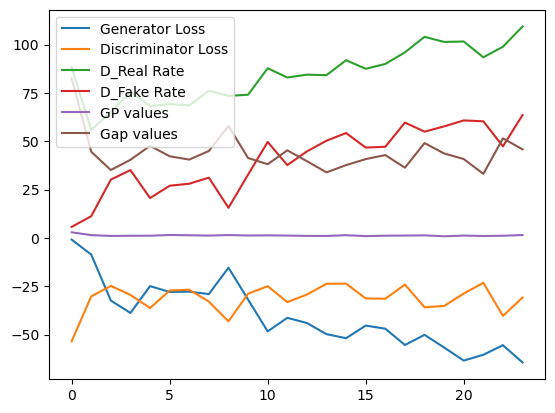

Starting epoch 24...
Epoch 24 | Generator Loss: -60.7113 | Discriminator Loss: -38.0473


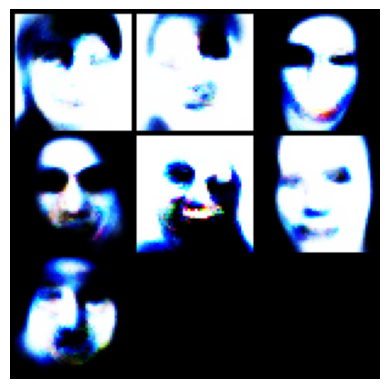

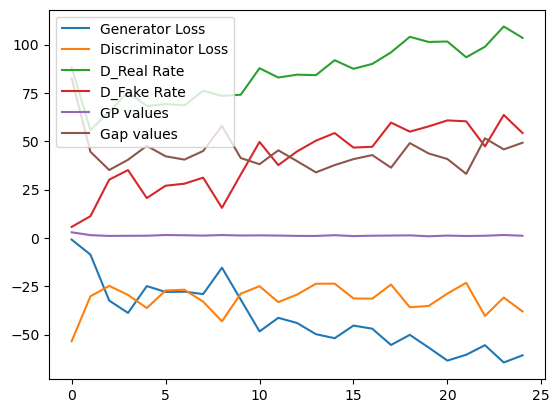

Starting epoch 25...
Epoch 25 | Generator Loss: -55.1775 | Discriminator Loss: -19.9911


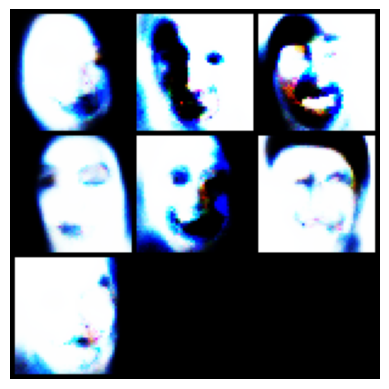

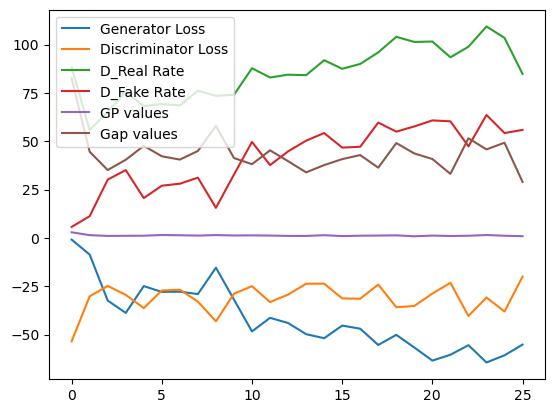

Starting epoch 26...
Epoch 26 | Generator Loss: -62.7685 | Discriminator Loss: -29.0590


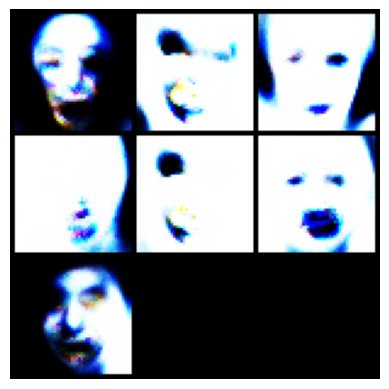

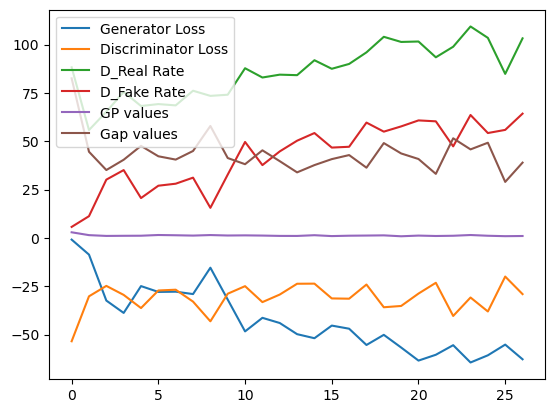

Starting epoch 27...
Epoch 27 | Generator Loss: -65.9749 | Discriminator Loss: -37.7453


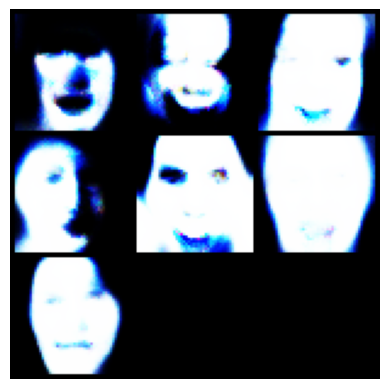

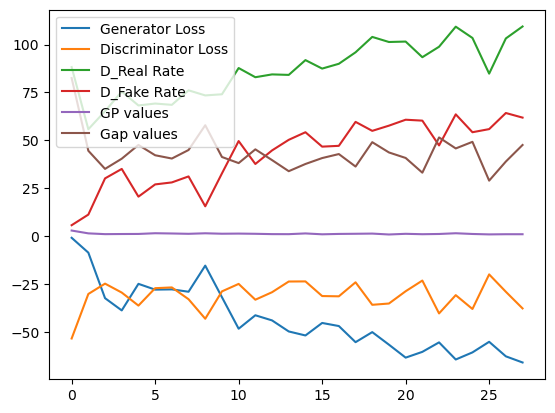

Starting epoch 28...
Epoch 28 | Generator Loss: -72.9385 | Discriminator Loss: -17.9878


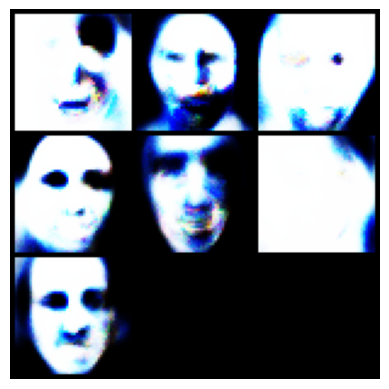

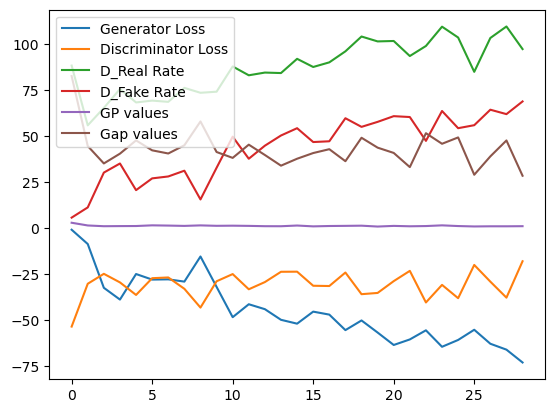

Starting epoch 29...


In [ ]:
num_epochs = 200
n_critic = 5  # Train the discriminator multiple times per generator update
display_step = 300
g_loss_list = []
d_loss_list = []
d_real_list = []
d_fake_list = []
gp_list = []
gap_list = []

for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    
    for i, (real_images, labels) in enumerate(data_loader):
        # Move data to GPU
        real_images, labels = real_images.cuda(), labels.cuda()
        
        # Train the discriminator (critic) multiple times per generator update
        for _ in range(n_critic):
            # Train with real and fake images
            d_loss, d_real, d_fake, gp, gap = discriminator_train_step(
                discriminator=discriminator,
                generator=generator,
                d_optimizer=d_optimizer,
                real_images=real_images,
                labels=labels,
                latent_space=latent_space,
                lambda_gp=10.0
            )
        
        # Train the generator
        g_loss = generator_train_step(
            discriminator=discriminator,
            generator=generator,
            g_optimizer=g_optimizer,
            batch_size=real_images.size(0),
            latent_space=latent_space,
            num_classes=len(dataset.classes)
        )

    # Switch generator to evaluation mode
    generator.eval()
    
    # Print the losses
    print(f'Epoch {epoch} | Generator Loss: {g_loss:.4f} | Discriminator Loss: {d_loss:.4f}')
    
    # Generate sample images
    z = torch.randn(7, latent_space).cuda()  # Latent space
    labels = torch.LongTensor(np.arange(7)).cuda()  # Generate labels for the batch
    sample_images = generator(z, labels).data.cpu()
    
    # Create a grid of generated images
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1, 2, 0).numpy()
    
    # Append losses to lists for plotting
    g_loss_list.append(g_loss)
    d_loss_list.append(d_loss)
    d_real_list.append(d_real)
    d_fake_list.append(d_fake)
    gp_list.append(gp)
    gap_list.append(gap)
    
    
    # Plot the generated image grid
    plt.imshow(grid)
    plt.axis('off')
    plt.show()
    
    # Plot the losses over time
    plt.plot(g_loss_list, label="Generator Loss")
    plt.plot(d_loss_list, label="Discriminator Loss")
    plt.plot(d_real_list, label="D_Real Rate")
    plt.plot(d_fake_list, label="D_Fake Rate")
    plt.plot(gp_list, label="GP values")
    plt.plot(gap_list, label="Gap values")
    plt.legend()
    plt.show()